# Relatório - Convolução no dominío da frequência

    Disciplina: Processamento Digital de sinais - PPGEEC

    Aluna: Rute Souza de Abreu

Este trabalho contém 3 simulações relacionadas a convolução no dominio da frequência, ele tem como objetivo demonstrar a implementação dos  algoritmos FFT, IFFT, sobreposição e soma e sobreposição e armazenamento, e através destes, realizar a filtragem de um sinal com ruído senoidal.

Este trabalho contém ainda, todos os códigos necessários para a realização de todas as simulações, sendo possível visualizá-lo de maneira interativa, através do link:

    http://nbviewer.jupyter.org/github/ruteee/ConvolucaoFrequencia/blob/master/Trabalho%20pds.ipynb 

Onde é possível ouvir todos os audio gerados, como ruído, voz, voz filtrada e etc.

## Funções Acessórias

Para realizar este trabalho foram criadas algumas funções acessórias, que consistem em funções que designadas para auxiliar o desenvolvimento das funções principais: FFT, IFFT, convolução a partir do método sobreposição e soma e convolução a partir do método de Sobreposição e armazenamento. 

São as funções: plot, calcular_numero_de_zeros, complete_zeros, get_fft_index, org_index_fft e wN. A seguir o descrição de cada função pode ser observada:

- **plot(y, title, *args)**: Função utilizada para desenhar todos os gráficos deste relatório
- **calcular_numero_de_zeros(vetor)**: Calcula o número de zeros as serem adicionados em um vetor para que este possua um comprimento da potência de 2 mais próxima a este.
- **complete_zeros(n, vector)**: Função que adiciona um numero de zeros, n, ao fim de um vetor
- **get_fft_index(i, width)**: Retorna o índice correto de um elemento da fft, ainda não organizada
- **org_index_fft(size_fft)**: Organiza os elementos da fft, na ordem correta.
- **wN(N, signal)**: Calcula o valor de $W_n = e^{-j2\pi/N}$
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd

In [2]:
def plot(y, title, *args):
    plt.figure(figsize=(16,4))
    plt.title(title)
    if(args):
        plt.plot(args[0],y)
    else:
        plt.plot(y)
    plt.show()

def calcular_numero_de_zeros(vetor):
    return int(2**np.ceil(np.log2(len(vetor))) - len(vetor))

def complete_zeros(n, vector):
    return np.concatenate([vector, np.zeros(n)])

def get_fft_index(i, width):
    i_fft = '{:0{width}b}'.format(i, width=width)
    return int(i_fft[::-1], 2)

def org_index_fft(size_fft):
    org_index_fft = []
    for i in np.arange(0,size_fft):
        numbits = int(np.ceil(np.log2(size_fft)))
        org_index_fft.append(get_fft_index(i,numbits))
    return org_index_fft

def wN(N, signal):
    return np.exp(signal*1j*2*np.pi/N)

# Simulação 1

Nesta simulação serão desenvolvidos os algoritmos de FFT, IFFT, Sobreposição e Soma e Sobrepososição e armazenamento. Estes algoritmos serão utilizados em conjunto para, inicialmente, convoluir dois sinais do tipo porta, podendo assim ser verificada a eficacia e corretude dos mesmos.

## Desenvolvimento da FFT

Para realizar o cálculo da FFT, foi implementada uma função recursiva que tem como base o algoritmo raiz de 2, com decimação na frequência. 

Neste algorimo a fft é calculada por partes utilizando as definições:
    $$ g[n] = x[n] + x[n + N/2]$$
    $$ h[n] = x[n] - x[n + N/2]$$
Onde N é o número de amostras da sequência que será transformada.

Na primeira chamada da função, o vetor de amostras é dividido em duas partes iguais, denominadas: p1 e p2, a partir dessas partes os vetores g e h são calculados. Para o calculo de h, é ainda realizado o ponderamento pelo fator $W_n$. Dessa forma temos que:
    $$ g = p1 + p2$$
    $$ h = (p1 - p2)*Wns$$
Onde $Wns$ é o vetor  composto por todos os $Wn$ calculados na chamada atual da função.

Calculados g e h, são realizadas duas chamadas da função fft, agora recebendo, em cada chamada, respectivamente, os vetores g e h. Este processo é repetido até que se chegue no caso base da função, que consiste em receber um vetor de tamanho 2; neste caso g e h, são:
    $$ g = x[0] + x[1]$$
    $$ h = x[0] - x[1]$$
    
Após todos os calculos de g e h serem realizados, uma concatenção destes vetores, que consistem do resultado final da fft, é feita. O vetor final é reorganizado e retornado ao usuário

O bloco abaixo mostra a implementação desta função

In [3]:
def fft(fact,N, vec=[]):
    
    size_v = len(vec)//2
    p1 = vec[0:len(vec)//2]
    p2 = vec[len(vec)//2:]

    if size_v == 1:
        g = vec[0] + vec[1]
        h = vec[0] - vec[1]
        return np.array([g,h])
    else:   
        wNs_tam = size_v
        Wns = wN(N, -1)**[(fact*i) for i in np.arange(0,wNs_tam)]
        
        g = p1 + p2
        h = (p1 - p2)*Wns
        
        fact = fact*2
        
        g = fft(fact, N, g)
        h = fft(fact, N, h)
    fft_ = np.concatenate([g,h])
    if fact == 2:
        fft_ = fft_[org_index_fft(len(fft_))]
    return fft_

## Desenvolvimento da IFFT

O desenvolvimento da IFFT é semelhante ao da FFT,diferindo apenas em dois aspectos, o cálculo de $W_n$, sendo este na IFFT: $e^{-j2\pi/N}$ e a ponderação final, já que neste caso o resultado final de ser multiplicado por $1/N$, onde N é o número de amostras da sequência que será inversamente transformada.

O bloco abaixo mostra o desenvolvimento do algoritmo da transformada inversa

In [4]:
def inverse_fft(fact,N, vec):
    size_v = len(vec)//2
    p1 = vec[0:len(vec)//2]
    p2 = vec[len(vec)//2:]

    if size_v == 1:
        g = vec[0] + vec[1]
        h = vec[0] - vec[1]
        return np.array([g,h])
    else:   
        wNs_tam = size_v
        Wns = wN(N, 1)**[(fact*i) for i in np.arange(0,wNs_tam)]
        
        g = p1 + p2
        h = (p1 - p2)*Wns
        
        fact = fact*2
        
        g =inverse_fft(fact, N, g)
        h = inverse_fft(fact, N, h)
    
    fft_ = np.concatenate([g,h])
    if fact == 2:
        fft_ = (fft_[org_index_fft(len(fft_))])/N
    return fft_
    

## Desenvolvimento do algoritmo: Sobreposição e soma (Over and Add)

Neste algoritimo a sequência x é dividida em blocos de tamanho $N -(M - 1)$ e a resposta ao impulso, h, de tamanho: $M$, é completada com zeros até o comprimento $N$ 

Como é realizada uma convolução circular, cada bloco de x, inicialmente com tamanho: N -(M - 1), é completado com zeros para que ambos, x e h, atinjam o mesmo comprimento $N$.  A partir daí, é realizada a convolução circular com as dfts dos blocos de x e h.

A saída final do algoritmo consiste em somar os resultados de cada convolução, já no dominio do tempo, realizando uma sobrepósição das $(M-1)$ amostras  finais do y anterior com a $(M-1)$ primeiras amostras do y atual.

In [5]:
def overlap_add(N, x , h ):
    M = int(len(h))
    No = N - M + 1
    num_blocks_x = int(np.ceil(len(x))/No)
    y = np.zeros(int(len(x)) + M-1, dtype='complex')
        
    not_div_flag = False

    if(len(x) % N != 0):
        not_div_flag = True
    
    h = complete_zeros((N-M),h)
    h_jw = fft(1, N, h)
    
    for i in np.arange(0,num_blocks_x):
        x_block = x[i*(No):(i+1)*No]
        x_block = complete_zeros(M-1, x_block)
        
        if(i == (num_blocks_x -1) and not_div_flag):
            num_zeros_add = N-len(x_block)
            x_block = np.concatenate([x_block, np.zeros(num_zeros_add)])
            
        x_block_jw = fft(1, N, x_block)
        conv_temp = inverse_fft(1, N, h_jw*x_block_jw)
        y[i*No: (i*No + N)] += conv_temp 
    return y

## Desenvolvimento do algoritmo: Sobreposição e armazenamento (Over and Save)

Neste algoritimo são consideradas as sequências x, entrada, e h, resposta ao impulso de tamanho: $M$. 
A resposta ao impulso é completada com zeros até que atinja o comprimento $N$, e a entrada é dividida em blocos de tamanho $L$, onde $L = N - (M-1)$ e posteriormente completada com zeros até que também atinja o comprimento $N$.

Com h e cada bloco de x com o mesmo tamanho, é realizada uma convolução circular atrávés das dfts das sequências. Para compor o sinal de saída cada convolução, já no dominio do tempo, é concatenada as demais, descartando-se as $(M-1) primeiras amostras de cada resultado.

In [6]:
def overlap_save(N, x, h):
    M = int(len(h))
    L = N - M + 1
    tam_x_in = L - (M-1) 

    number_blocks_x = int(np.ceil(len(x)/L))
   
    y = np.zeros(0, dtype='complex')
    h = complete_zeros((N-M),h)
    not_div_flag = False

    if(len(x) % N != 0):
        not_div_flag = True
        
    x_block = np.concatenate([np.zeros(M-1), x[0: L]])
    
    conv_freq = fft(1, N,x_block)* fft(1, N, h)
    conv_temp = inverse_fft(1, N, conv_freq)
    
    y = np.concatenate([y,conv_temp[(M-1):]])
    for j in np.arange(1, number_blocks_x):
        x_block = x[j*L - (M-1) : ((j+1)*L)]
        
        if(j == (number_blocks_x -1) and not_div_flag):
            num_zeros_add = N-len(x_block)
            x_block = np.concatenate([x_block, np.zeros(num_zeros_add)])
            
        h_jw = fft(1, N, h)
        x_block_jw = fft(1, N, x_block)
      
        conv_temp = inverse_fft(1, N, h_jw*x_block_jw)

        y = np.concatenate([y,conv_temp[(M-1):]])
    return y
    

## Criação e plots do sinal tipo porta de 3000 pontos e de 220 pontos

Para testar os métodos de sobreposição e soma, sobreposição e armazenamento, fft e ifft foram criados dois sinais do tipo porta, signal_port_3000 com 3000 amostras e signal_port_220 com 220 amostras. O bloco abaixo mostra esta criação

In [7]:
signal_port_3000 = np.ones(3000)
signal_port_220 = np.ones(220)

### Plot dos sinais porta, (Sinal no tempo, e FFT, em fase e magnitude)

#### Sinal porta de 3000 amostras

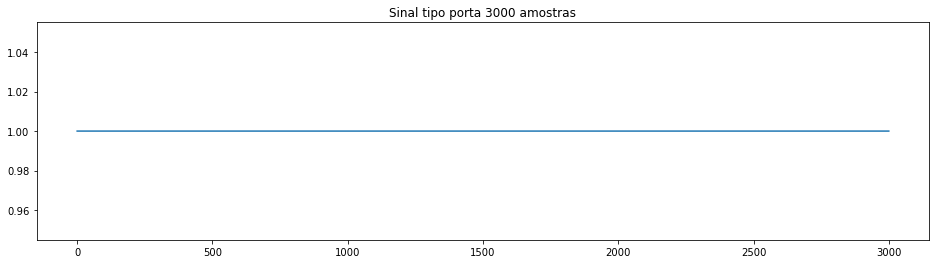

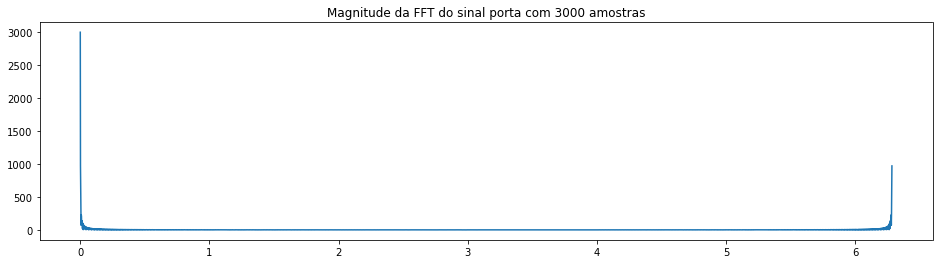

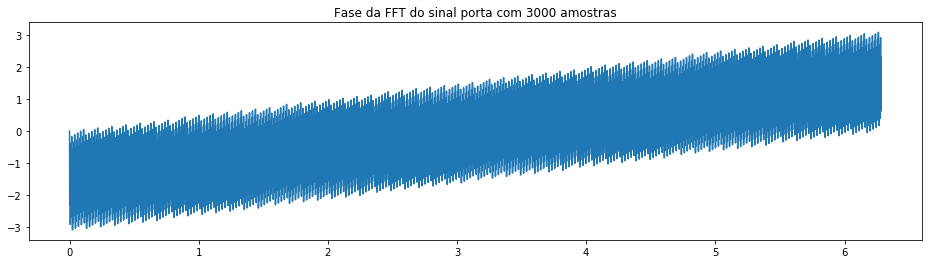

In [8]:
signal_port_3000_add = complete_zeros(calcular_numero_de_zeros(signal_port_3000), signal_port_3000)
fft_3000 = np.fft.fft(signal_port_3000_add)

plot(signal_port_3000, "Sinal tipo porta 3000 amostras")
plot(np.absolute(fft_3000), 'Magnitude da FFT do sinal porta com 3000 amostras',np.linspace(0,2*np.pi, len(fft_3000)))
plot(np.angle(fft_3000), 'Fase da FFT do sinal porta com 3000 amostras',np.linspace(0,2*np.pi, len(fft_3000)) )

#### Sinal porta de 220 amostras

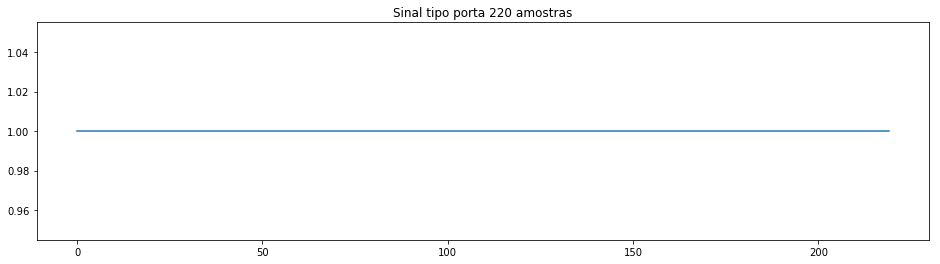

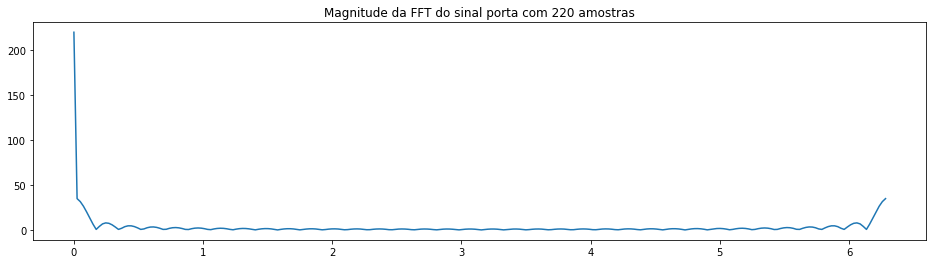

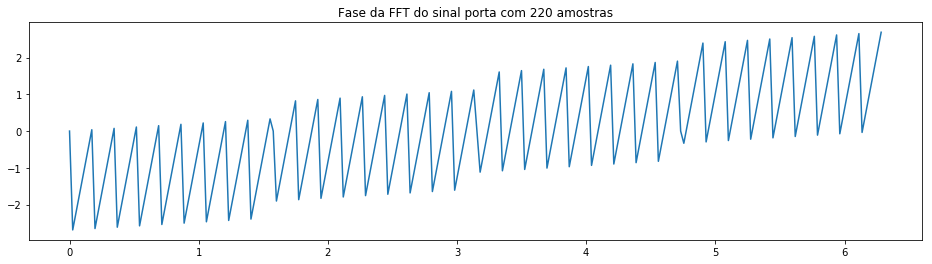

In [9]:
signal_port_220_add = complete_zeros(calcular_numero_de_zeros(signal_port_220), signal_port_220)
fft_220 = np.fft.fft(signal_port_220_add)

plot(signal_port_220, "Sinal tipo porta 220 amostras")
plot(np.absolute(fft_220), 'Magnitude da FFT do sinal porta com 220 amostras',np.linspace(0,2*np.pi, len(fft_220)))
plot(np.angle(fft_220), 'Fase da FFT do sinal porta com 220 amostras',np.linspace(0,2*np.pi, len(fft_220)) )


### Gráficos da convolução utilizando o método Sobreposição e soma

Os gráficos abaixo mostram o resultado da convolução no tempo e na frequencia utilizando o algoritmo de sobreposição e soma

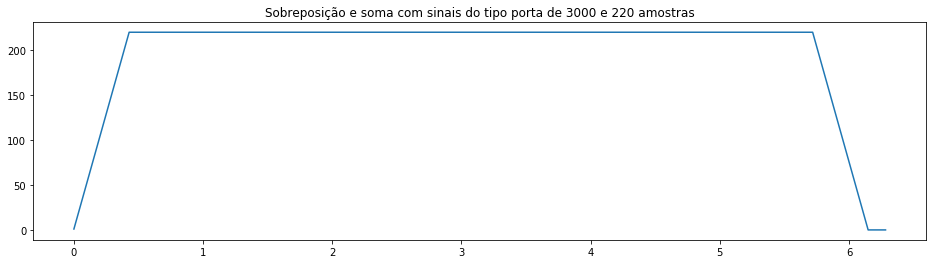

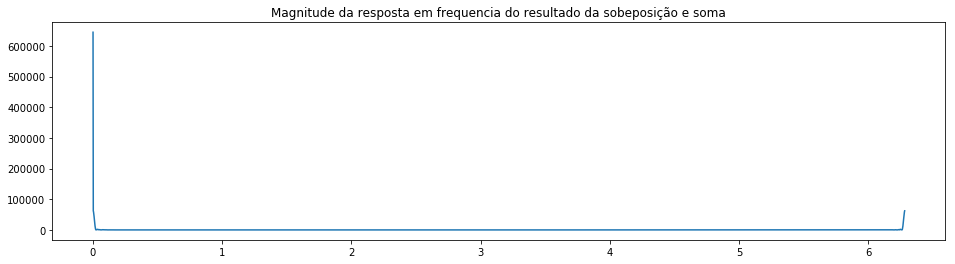

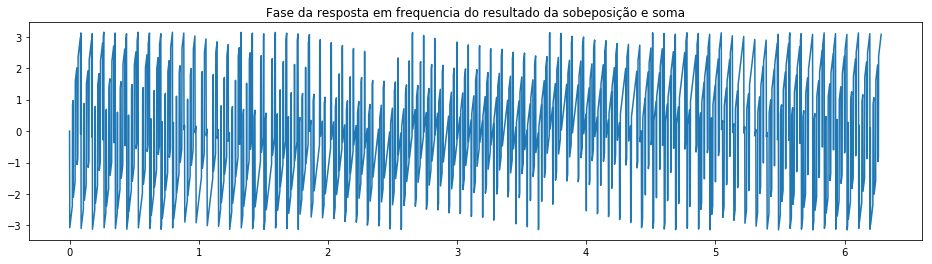

In [10]:
over_and_add = overlap_add(512, signal_port_3000, signal_port_220)
fft_over_add = np.fft.fft(over_and_add)

plot(np.absolute(over_and_add), "Sobreposição e soma com sinais do tipo porta de 3000 e 220 amostras", np.linspace(0,2*np.pi, len(over_and_add)))
plot(np.absolute(fft_over_add), 'Magnitude da resposta em frequencia do resultado da sobeposição e soma', np.linspace(0,2*np.pi, len(fft_over_add)))
plot(np.angle(fft_over_add), 'Fase da resposta em frequencia do resultado da sobeposição e soma', np.linspace(0,2*np.pi, len(fft_over_add)))

Como era esperado, o sinal de saída da convolução entre dois sinais do tipo porta, tem a forma trapezoidal, é possível ainda ver uma pequena cauda de zeros no gráfico. Isso acontece porque o algoritmo utilizado trabalha com adição de zeros nos blocos de x e h, neste caso no sinal tipo porta de 3000 e no sinal tipo porta de 220 amostras, essa adição é necessária para que se possa obter uma convolução linear dos sinais, que exige que o tamanho de cada sub-bloco dos sinais tenham o mesmo comprimento, afim de produzir o mesmo resultado de uma convolução usual.

### Gráficos da convolução utilizando o método Sobreposição e armazenamento

Os gráficos abaixo mostram o resultado da convolução no tempo e na frequencia utilizando o algoritmo de sobreposição e armazenamento

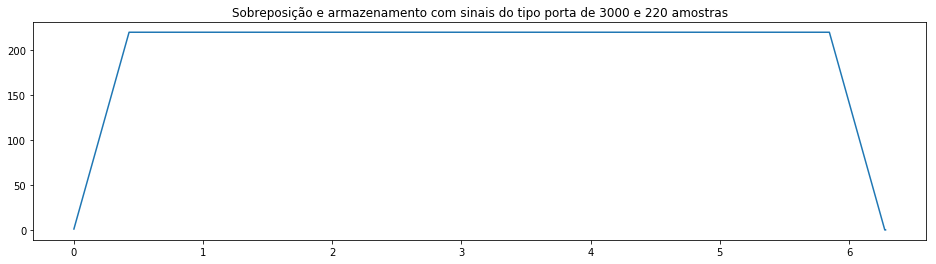

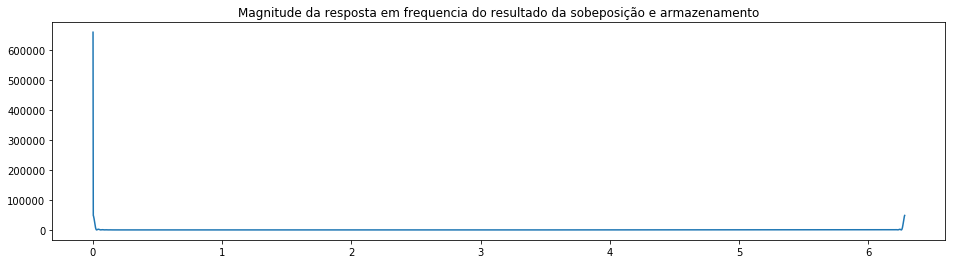

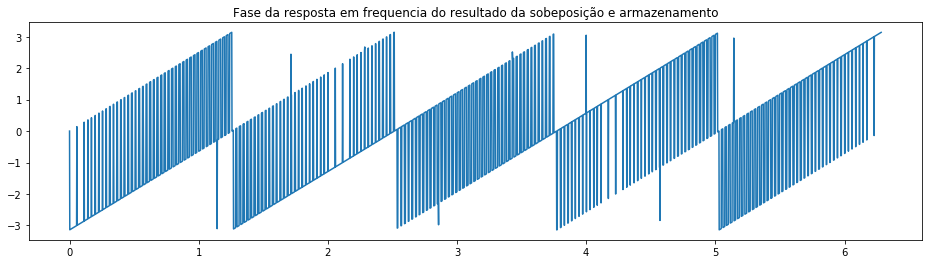

In [11]:
over_and_save = overlap_save(512, signal_port_3000, signal_port_220)
fft_over_save = np.fft.fft(over_and_save)

plot(np.absolute(over_and_save), "Sobreposição e armazenamento com sinais do tipo porta de 3000 e 220 amostras", np.linspace(0,2*np.pi, len(over_and_save)))
plot(np.absolute(fft_over_save), 'Magnitude da resposta em frequencia do resultado da sobeposição e armazenamento', np.linspace(0,2*np.pi, len(fft_over_save)))
plot(np.angle(fft_over_save), 'Fase da resposta em frequencia do resultado da sobeposição e armazenamento', np.linspace(0,2*np.pi, len(fft_over_save)))



Assim como no gráfico do algoritmo anterior, esta convolução posui a mesma forma trapezoidal, assim como um pequena cauda de zeros, devido ao mesmo motivo mencionado anteriormente.

## Convolução utilizando a função 'convolve' do numpy (Python)

Para fazer uma comparação dos resultados, são plotados abaixo os resultados utilizando a função *convolve* da biblioteca *numpy* da liguagem *Pyhton*

In [12]:
np_conv = np.convolve(signal_port_3000, signal_port_220)

## Gráficos da convolução original do python

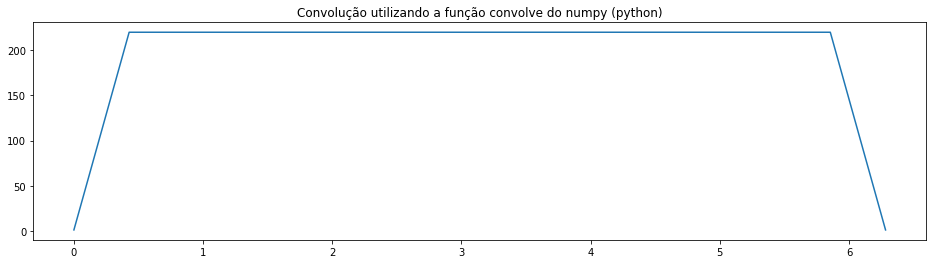

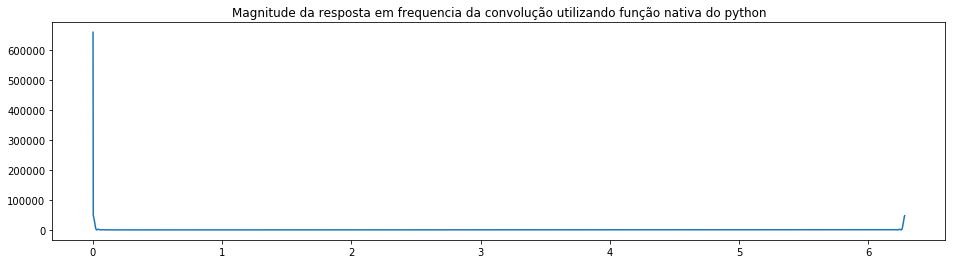

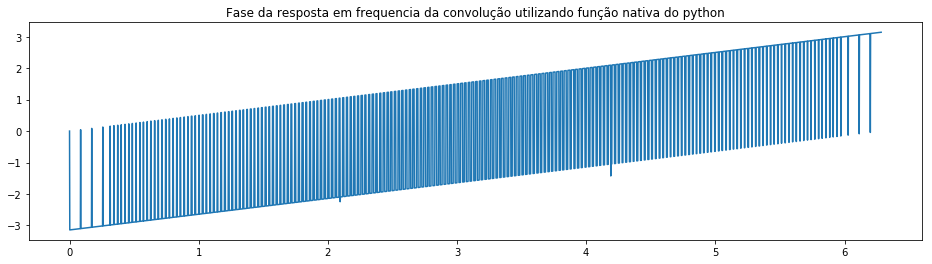

In [13]:

fft_np_conv= (np.fft.fft(np_conv))

plot(np.absolute(np_conv), 'Convolução utilizando a função convolve do numpy (python)', np.linspace(0,2*np.pi, len(np_conv)))
plot(np.absolute(fft_np_conv), 'Magnitude da resposta em frequencia da convolução utilizando função nativa do python', np.linspace(0,2*np.pi, len(fft_np_conv)))
plot(np.angle(fft_np_conv), 'Fase da resposta em frequencia da convolução utilizando função nativa do python', np.linspace(0,2*np.pi, len(fft_np_conv)))


É possível notar neste gráfico a semelhança com os anteriores, a excessão da cauda de zeros. Isso mostra que os algoritmos implementados neste trabalho produziram um resultado correto

# Simulação 2
    
Nesta simulação, um audio de voz da autora deste trabalho é gravado por 10s a uma taxa de amostragem de 8kHz, apoós isto, é adicionado a esse áudio um ruído senoidal de 2Khz.

O objetivo desta simulação é utilizar o filtro passa baixas, dado, para, através dos algoritmos de sobreposição e soma e sobreposição e armazenamento, filtrar o ruído senoidal adicionado.

## Criação do filtro, h[n]

O bloco de código abaixo cria o filtro h[n] de acordo com a expressão dada no trabalho
$$h[n] =\frac{sin(0.325(n-62))}{\pi(n-62)}\left [ 0.5 - 0.5cos(\frac{2\pi n}{124}) \right]$$

com $$ 0 < n < 124$$

In [14]:
n = np.arange(0,125)
h = ((np.sinc(0.325*(n - 62)))*(0.325))* (0.5 - 0.5*np.cos(2*np.pi*n/124))

## Plots do filtro no tempo e resposta em frequência em fase e magnitude.

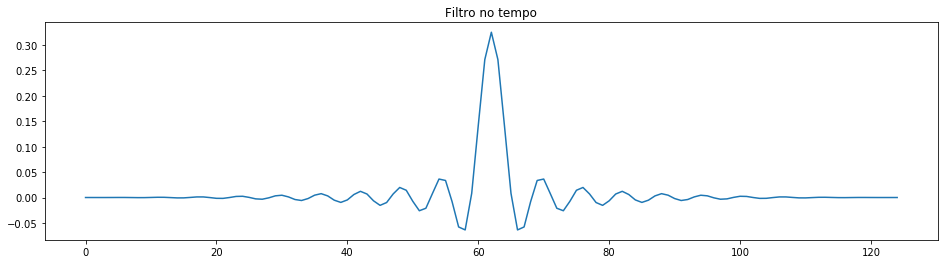

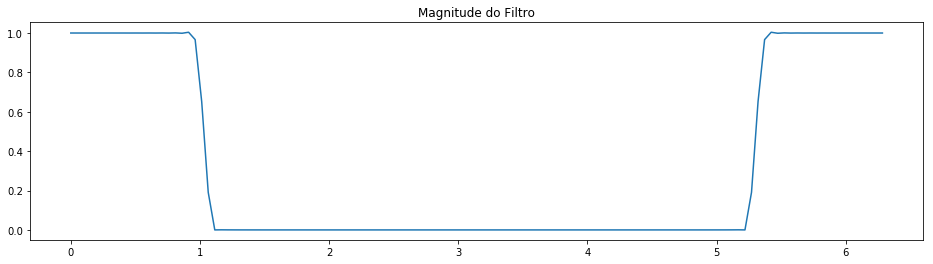

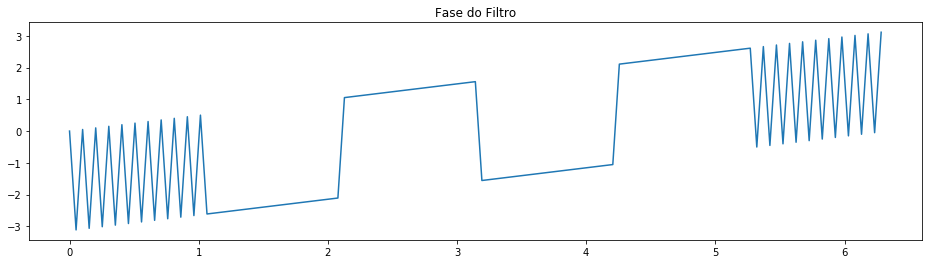

In [15]:
h_jw = np.fft.fft(h)
plot(h, "Filtro no tempo")
plot(np.absolute(h_jw), "Magnitude do Filtro", np.linspace(0,2*np.pi, len(h)))
plot(np.angle(h_jw), "Fase do Filtro", np.linspace(0,2*np.pi, len(h)))

## Importação dos arquivos de áudio

O áudio de voz, foi gravado através do *software* audacity e o ruído senoidal com $f = 2kHz$, foi gerado pelo mesmo software a uma taxa de $8kHz$. Posteriormente estes audios foram importados como mostra o trecho de código abaixo.

In [16]:
fs, data_rute = wavfile.read('Audios/voz_de_rute.wav')
fs, data_ruido = wavfile.read('Audios/ruido.wav')

## Áudio original da voz do autor

A partir do trecho de código abaixo é possívelo audio de voz, da autora, gravado.

In [17]:
ipd.Audio(data_rute, rate=8000)

### Plots do sinal de audio de voz

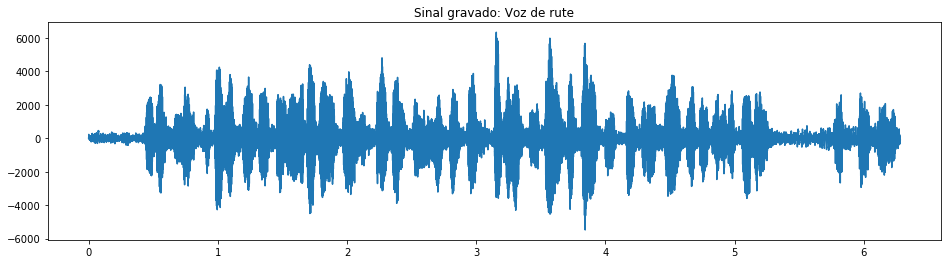

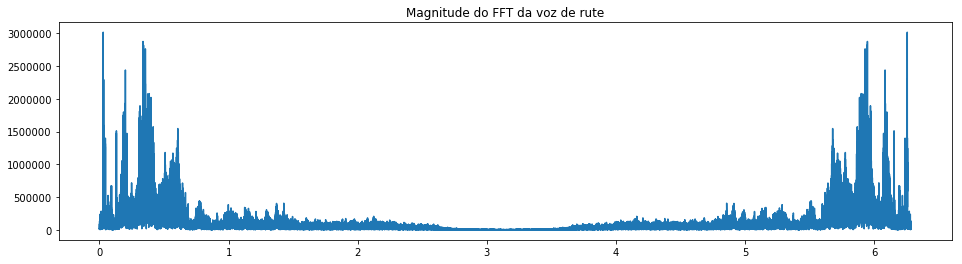

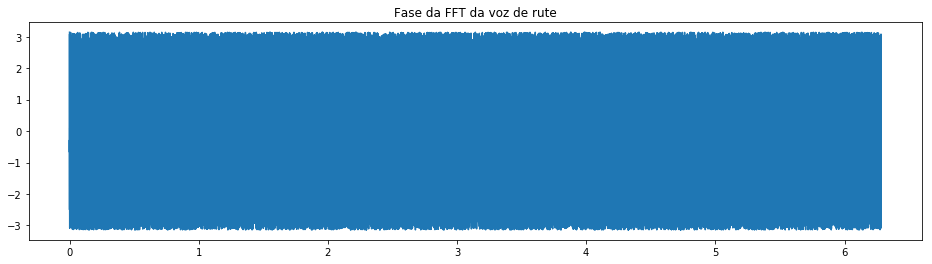

In [18]:
fff_rute = np.fft.fft(data_rute)

plot(np.real(data_rute), 'Sinal gravado: Voz de rute',np.linspace(0,2*np.pi, len(data_rute)))
plot(np.absolute(fff_rute), 'Magnitude do FFT da voz de rute',np.linspace(0,2*np.pi, len(fff_rute)))
plot(np.angle(fff_rute), 'Fase da FFT da voz de rute',np.linspace(0,2*np.pi, len(fff_rute)))

## Ruído

A partir do trecho de código abaixo é possível ouvir o audio do ruído senoidal.

In [19]:
ipd.Audio(data_ruido, rate=8000)

### Plot da fft, em fase e magnitude, do ruído

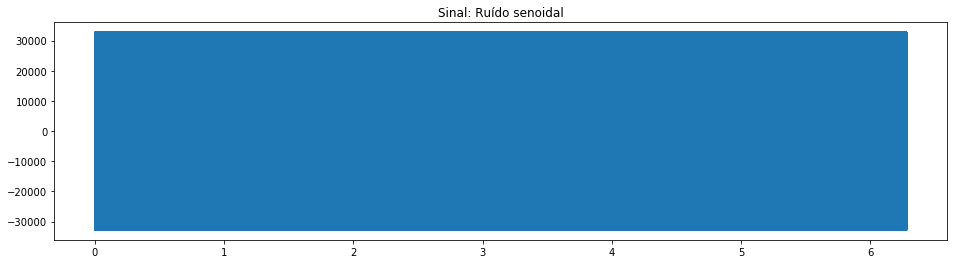

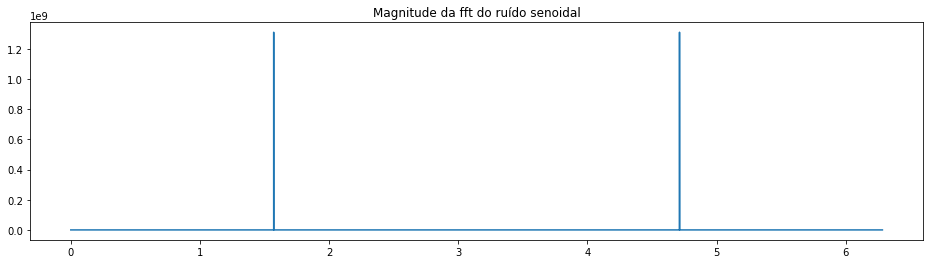

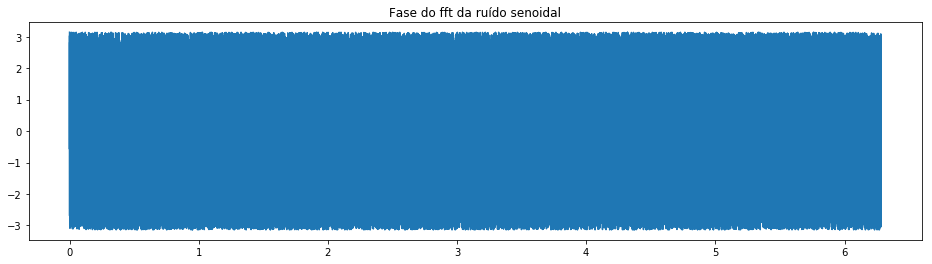

In [20]:
fft_ruido = np.fft.fft(data_ruido)

plot(np.real(data_ruido), 'Sinal: Ruído senoidal',np.linspace(0,2*np.pi, len(data_ruido)))
plot(np.absolute(fft_ruido), 'Magnitude da fft do ruído senoidal',np.linspace(0,2*np.pi, len(fft_ruido)))
plot(np.angle(fft_ruido), 'Fase do fft da ruído senoidal',np.linspace(0,2*np.pi, len(fft_ruido)))


## Sinal de voz com adição do ruído

No bloco de código abaixo o sinal de ruído é adicionado ao sinal de voz. É possível ouvir a mistrura dos dois sinais através deste bloco.

In [21]:
voz_com_ruido = data_rute+0.1*data_ruido
ipd.Audio(voz_com_ruido, rate=8000)

### Plots do sinal de voz com ruído adicionado 

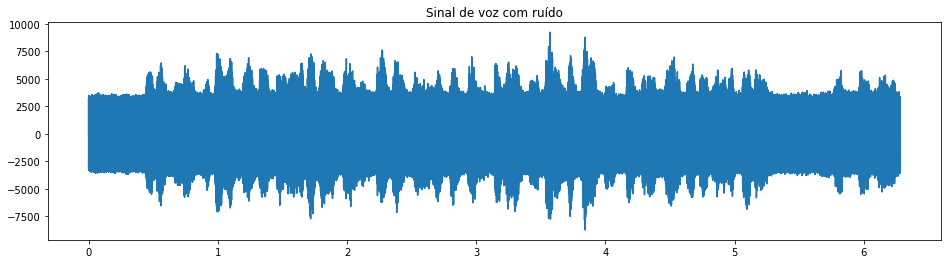

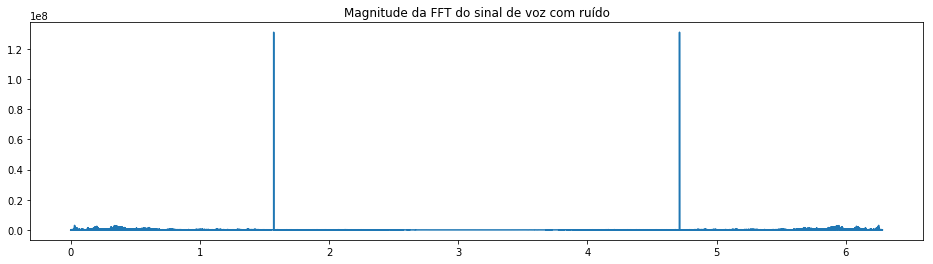

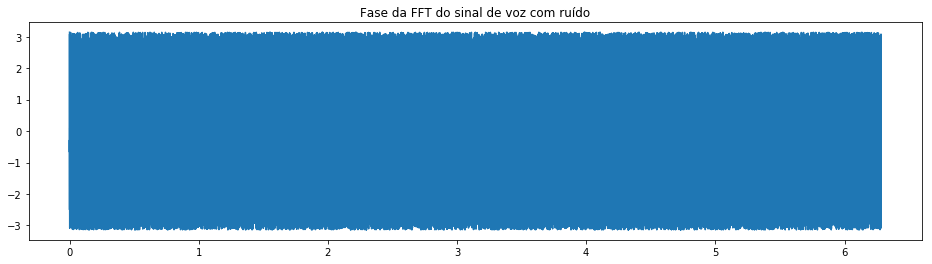

In [22]:
voz_com_ruido_fft = np.fft.fft(voz_com_ruido)


plot(np.real(voz_com_ruido), 'Sinal de voz com ruído', np.linspace(0,2*np.pi, len(voz_com_ruido)))
plot(np.absolute(voz_com_ruido_fft), 'Magnitude da FFT do sinal de voz com ruído', np.linspace(0,2*np.pi, len(voz_com_ruido_fft)))
plot(np.angle(voz_com_ruido_fft), 'Fase da FFT do sinal de voz com ruído', np.linspace(0,2*np.pi, len(voz_com_ruido_fft)))

## Voz filtrada utilizando o método de Sobreposição e soma e filtro passa-baixas
Nos blocos abaixo é possível ouvir a voz filtrada com filtro passa baixas, h, utilizando o método de sobreposição e soma

In [23]:
voz_filtrada_over_and_add = overlap_add(512, voz_com_ruido, h)

In [24]:
ipd.Audio(np.real(voz_filtrada_over_and_add), rate=8000)

### Plot da fft, em magnitude e fase, do sinal de voz filtrado

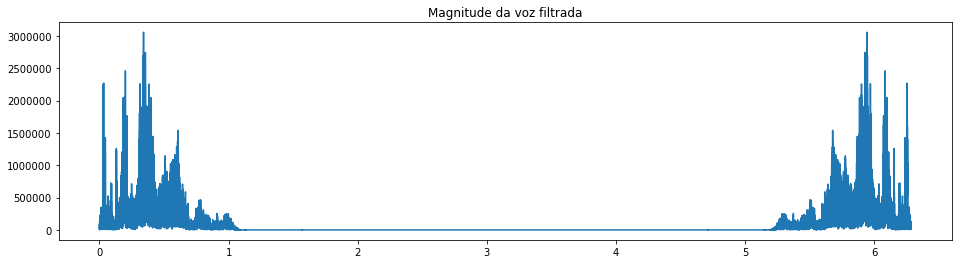

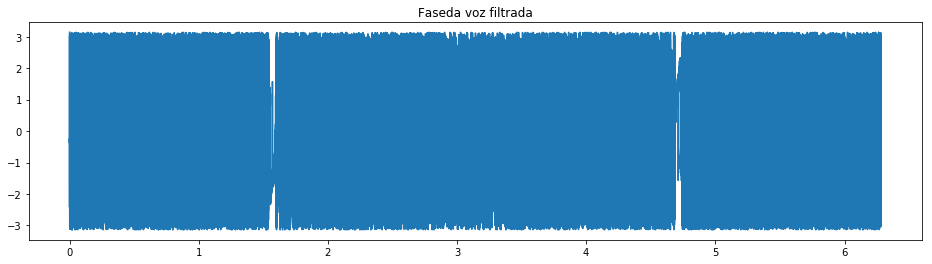

In [25]:
fft_voz_filtrada_soma = np.fft.fft(voz_filtrada_over_and_add)
plot(np.absolute(fft_voz_filtrada_soma), 'Magnitude da voz filtrada', np.linspace(0,2*np.pi, len(fft_voz_filtrada_soma)))
plot(np.angle(fft_voz_filtrada_soma), 'Faseda voz filtrada', np.linspace(0,2*np.pi, len(fft_voz_filtrada_soma)))

## Voz filtrada utilizando o método de Sobreposição e armazenamento com filtro passa-baixas

Nos blocos abaixo é possível ouvir o sinal de voz filtrado com filtro passa-baixas h, utilizando o método de sobreposição e armazenamento

In [26]:
voz_filtrada_over_and_save = overlap_save(512, voz_com_ruido, h)

In [27]:
ipd.Audio(np.real(voz_filtrada_over_and_save), rate=8000)

### Plot da fft, em magnitude e fase, do sinal de voz filtrado

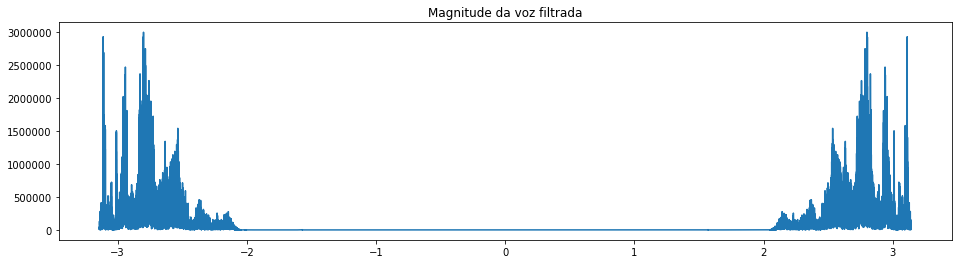

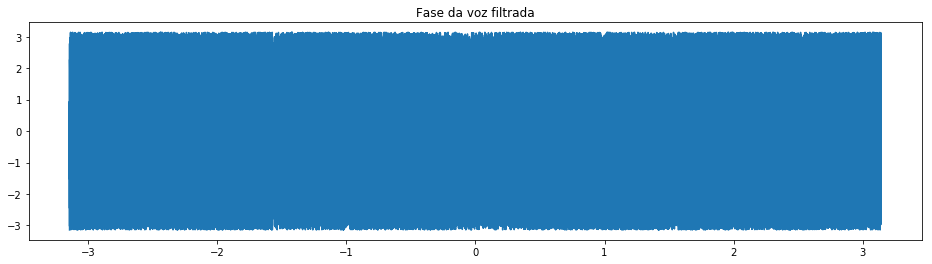

In [28]:
voz_filtrada_over_and_save_add = complete_zeros(calcular_numero_de_zeros(voz_filtrada_over_and_save), voz_filtrada_over_and_save)
voz_filtrada_save_fft = fft(1, len(voz_filtrada_over_and_save_add), voz_filtrada_over_and_save_add)

plot(np.absolute(voz_filtrada_save_fft), 'Magnitude da voz filtrada', np.linspace(-np.pi,np.pi, len(voz_filtrada_save_fft)))
plot(np.angle(voz_filtrada_save_fft), 'Fase da voz filtrada', np.linspace(-np.pi,np.pi, len(voz_filtrada_save_fft)))

# Simulação 3: Projeto de filtro rejeita faixas para rejeitar o ruído de 2kHz

O obejtivo desta simulação foi projetar um filtro rejeita-faixas para remover o ruído senoidal de 2kHz, adicionado a voz da autora, na simulação anterior.

## Projeto do filtro
   Para o projeto deste filtro foram uilizados frequências de corte $W_c1 = 0.45\pi$ e  $W_c2 = 0.55\pi$ com $\delta_1 = \delta_2= 0.01$. O método de filtragem foi o de filragem por janelamento, utilizando a janela de Haninng. Escolhendo $w_{s1} = 0.475\pi$, $w_{s2} = 0.575\pi$ e $w_{p1} = 0.425\pi$ foi obtido um M = 97, para a janela escolhida.
   
   A função do filtro, h, ideal é definida como: $$\frac{sin(wc_{c1}n) -sin(w_{c2}n) }{\pi n}\ para\ |n|\ >\ 0 $$ e
   $$ 1 -\frac{wc_{c2} -w_{c1}}{\pi }\ para\ n\ =\ 0$$
   
  A equação da janela de Hanning é dada por $$ 0.5\left [ 1-\frac{cos(2\pi n)}{N-1} \right ]\ para\ |n|\ > 0$$
  
  
  
  e $$ 0\ caso\ contrário$$
   

In [29]:
wc1 = 1.8*(np.pi*2*1/8)
wc2 = 2.2*(np.pi*2*1/8)

ws1 = 1.9*(np.pi*2*1/8)
ws2 = 2.1*(np.pi*2*1/8)

wp1 = 2*wc1-ws1

deltaW = np.absolute(ws1-wp1)

deltaF = deltaW/(2*np.pi)

M = int(3.1/deltaF)

n = np.arange(0,M+1)

h_rejeita_faixa = np.zeros(M+1)

for i in np.arange(0,len(n)):
    if i != M/2:
        h_rejeita_faixa[i] = (1/((i - M/2)*np.pi))*(np.sin(wc1*(i - M/2)) - np.sin(wc2 *(i - M/2)))*(0.5 - 0.5*np.cos(2*np.pi*i/M))
    else:
        h_rejeita_faixa[i] =  1 - ((wc2 -wc1)/np.pi)


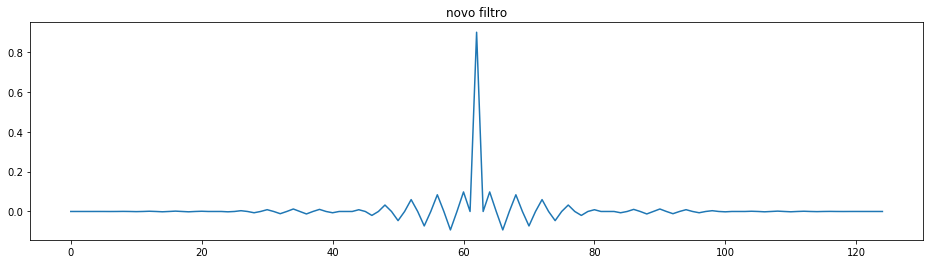

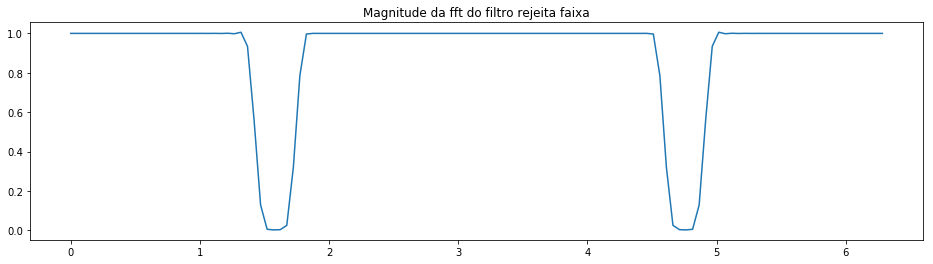

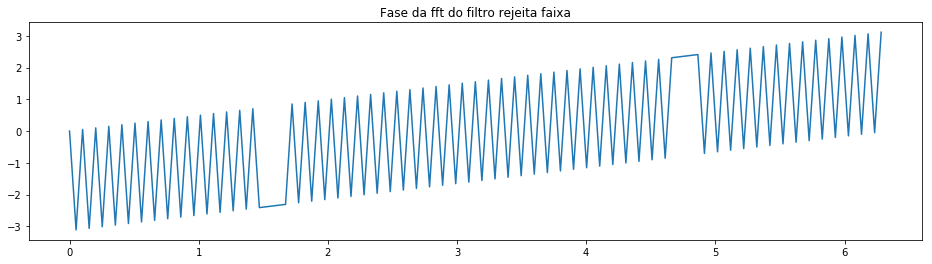

In [30]:
plot(h_rejeita_faixa,'novo filtro')
h_rejeita_faixa_fft = np.fft.fft(h_rejeita_faixa)

plot(np.absolute(h_rejeita_faixa_fft), 'Magnitude da fft do filtro rejeita faixa', np.linspace(0,2*np.pi, len(h_rejeita_faixa_fft)))
plot(np.angle(h_rejeita_faixa_fft), 'Fase da fft do filtro rejeita faixa', np.linspace(0,2*np.pi, len(h_rejeita_faixa_fft)))


## Utilização dos algoritimos: Sobreposição e soma e Sobreposição e armazenamento

Utilizando os algoritmos de sobreposição e soma e sobreposição e armazenamento, a voz com ruído senoidal adicionado, foi filtrada utilizando, agora, o filtro rejeita faixas projetado.


### Sobreposição e soma com o novo filtro

In [31]:
voz_novo_filtro_over_add = overlap_add(512, voz_com_ruido, h_rejeita_faixa)

In [32]:
ipd.Audio(np.real(voz_novo_filtro_over_add), rate=8000)

#### Plot da fft do sinal, em fase e magnitude, filtrado utilizando o filtro rejeita faixa

Os gráficos abaixo estão variando, no eixo horizontal, de $0$ à $2\pi$.

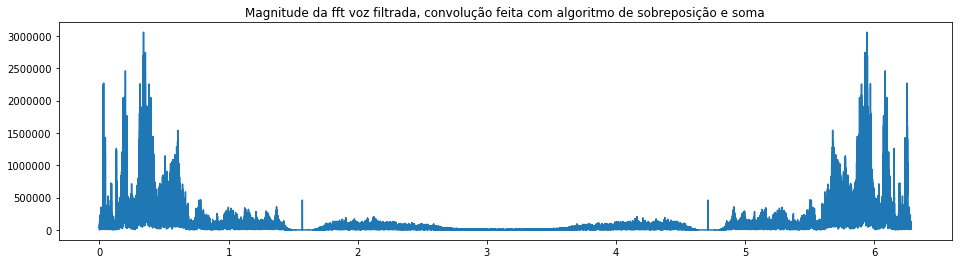

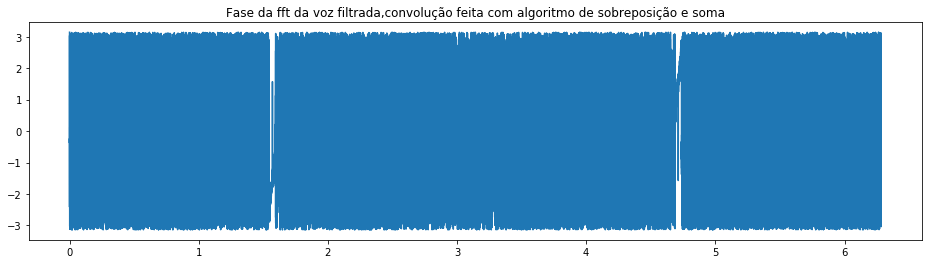

In [33]:
voz_novo_filtro_over_add_fft = np.fft.fft(voz_novo_filtro_over_add)
plot(np.absolute(voz_novo_filtro_over_add_fft), 'Magnitude da fft voz filtrada, convolução feita com algoritmo de sobreposição e soma', np.linspace(0,2*np.pi, len(voz_novo_filtro_over_add_fft)))
plot(np.angle(voz_novo_filtro_over_add_fft), 'Fase da fft da voz filtrada,convolução feita com algoritmo de sobreposição e soma', np.linspace(0,2*np.pi, len(voz_novo_filtro_over_add_fft)))

Pelo gráfico de magnitude da transformada da voz filtrada, podemos ver que o pico do ruído em 2kHz, no gráfico
entre s valores de 1rad e 2rad  e 4rad e 5rad, foi quase que completamente atenuado, pelo filtro rejeita faixas projetado. Isso mostra que a convolução realizada pelo algoritmo de sobreposição e soma foi realizada corretamente, já que o filtro foi aplicado ao sinal de maneira satisfatória.

### Sobreposição e armazenamento com o novo filtro

In [34]:
voz_novo_filtro_over_save= overlap_save(512, voz_com_ruido, h_rejeita_faixa)

In [35]:
ipd.Audio(np.real(voz_novo_filtro_over_save), rate=8000)

### Plot da fft do sinal, em fase e magnitude, filtrado utilizando o filtro rejeita faixa

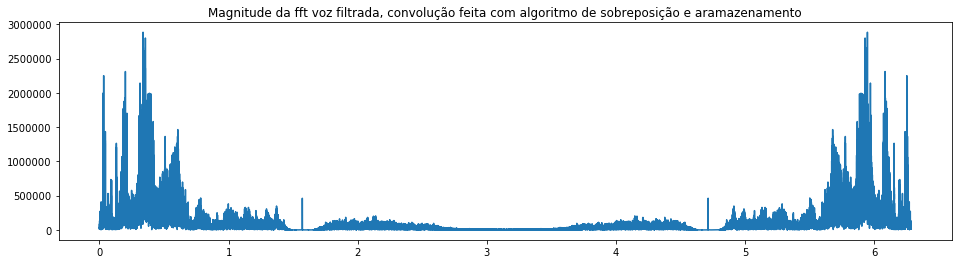

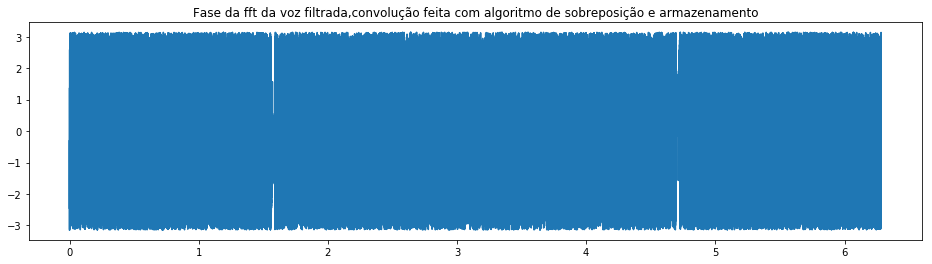

In [36]:
voz_novo_filtro_over_save_fft = np.fft.fft(voz_novo_filtro_over_save)

plot(np.absolute(voz_novo_filtro_over_save_fft), 'Magnitude da fft voz filtrada, convolução feita com algoritmo de sobreposição e aramazenamento', np.linspace(0,2*np.pi, len(voz_novo_filtro_over_save_fft)))
plot(np.angle(voz_novo_filtro_over_save_fft), 'Fase da fft da voz filtrada,convolução feita com algoritmo de sobreposição e armazenamento', np.linspace(0,2*np.pi, len(voz_novo_filtro_over_save_fft)))

Assim como o método de sobreposição e soma, o método de sobreposição e armazenamento convoluiu os sinais de maneira 
correta. Podemos ver que o filtro rejeita faixas foi aplicado ao sinal, removendo o sinal de ruído. É possível ver
no gráfico de magnitude da voz filtrada, na região entre 1rad e 2rad, assim como na região entre 4rad e 5rad, que o pico do  sinal de ruído foi bastante atenuado, ficando praticamente nulo.